In [12]:
from sys import prefix
"""
Theoretical metric proven "good articles" of the wikispeedia dataset.
Osc, nov 2024
"""

'\nTheoretical metric proven "good articles" of the wikispeedia dataset.\n\nOsc, nov 2024\n'

In [13]:
#pip install -r requirements.txt

In [1]:
from src.load_data import *
from src.graph_data import *
import pandas as pd
from collections import defaultdict

['/Users/oscargoudet/Desktop/ada-2024-project-adaholiks', '/opt/anaconda3/envs/ada_project/lib/python312.zip', '/opt/anaconda3/envs/ada_project/lib/python3.12', '/opt/anaconda3/envs/ada_project/lib/python3.12/lib-dynload', '', '/opt/anaconda3/envs/ada_project/lib/python3.12/site-packages', '/Users/oscargoudet/Desktop', '/Users/oscargoudet/Desktop']
---- WARNING: The following articles have a problem: ----
Badugi has no links (out-edges) listed.
Color_Graphics_Adapter has no links (out-edges) listed.
Directdebit has no category listed.
Directdebit has no links (out-edges) listed.
Donation has no category listed.
Donation has no links (out-edges) listed.
Douglas_DC-4 has no links (out-edges) listed.
Duchenne_muscular_dystrophy has no links (out-edges) listed.
Friend_Directdebit has no category listed.
Klinefelter%27s_syndrome has no links (out-edges) listed.
Local_community has no links (out-edges) listed.
Lone_Wolf_%28gamebooks%29 has no links (out-edges) listed.
Osteomalacia has no lin

### List of theoretical "good nodes"

Here, for every node, we count the times it is part of a shortest path. By doing this, we obtain a list of nodes that are often good choices when playing the wikispeedia game as they are more often than not part of a shortest path.

## First step is getting all the source target pair that exist in the played games

In [2]:
articles = load_articles_into_df()
categories = load_categories()
links = load_links()
paths_finished = load_paths_finished()
paths_unfinished = load_paths_unfinished()
distances = load_distances()

# Add a "finished" column to paths_finished
paths_finished['finished'] = True
paths_finished['failure_reason'] = None
# Extract the start_article and target_article from the path column
paths_finished['start_article'] = paths_finished['path'].apply(lambda x: x.split(';')[0])
paths_finished['target_article'] = paths_finished['path'].apply(lambda x: x.split(';')[-1])

# Same to paths_unfinished
paths_unfinished['finished'] = False
# Clean the paths_unfinished dataframe
# Rename 'type' to 'failure_reason'
paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)
# extract the start_article from the `path` column
paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

paths = pd.concat([paths_finished, paths_unfinished])

finished_paths = paths[paths['finished'] == True]

unique_pairs = finished_paths[['start_article', 'target_article']].drop_duplicates()

pair_counts = finished_paths.groupby(['start_article', 'target_article']).size().reset_index(name='count')

# Display the pairs along with their counts
pair_counts

,start_article,target_article,count
0,10th_century,11th_century,3
1,10th_century,Banknote,1
2,10th_century,Country,1
3,10th_century,Harlem_Globetrotters,2
4,10th_century,History_of_democracy,1
...,...,...,...
28713,Zulu,Language,1
28714,Zulu,Slovenia,2
28715,Zürich,Billie_Holiday,1
28716,Zürich,Mediterranean_Sea,1


Now we check the articles that appear the most in those shortest paths between those pairs

In [24]:
# Here beware, it takes very long to run as the operation is computationaly expensive 
from collections import defaultdict

node_counts = defaultdict(int)

errors = 0

lengths = []

for _, row in pair_counts.iterrows():
    source = row['start_article']
    target = row['target_article']

    try:

        all_paths = list(nx.all_shortest_paths(G, source=source, target=target))

        nb_of_shortest_paths = len(all_paths)

        lengths.append(nb_of_shortest_paths)
        
        for path in all_paths:
            for node in path:
                if node != source and node != target:
                    node_counts[node] += 1/nb_of_shortest_paths

    except nx.NetworkXNoPath:
        # Skip this source-target pair if no path exists
        errors +=1


SP_article_count = pd.DataFrame(node_counts.items(), columns=['Article', 'Count'])

# Sort by the 'ShortestPathCount' column in ascending order
SP_article_count = SP_article_count.sort_values(by='Count', ascending=False)
SP_article_count.head(20)

,Article,Count
27,United_States,2778.997827
124,United_Kingdom,1128.250118
77,Europe,809.943234
79,England,746.721314
174,Africa,716.774062
2,Germany,614.765519
92,World_War_II,534.374375
230,Japan,526.817727
143,Earth,480.186276
1,France,417.042087


# Articles most present in players finished paths
We can compare those results to the List of articles that were sucessful in players finished paths 
Here we look at the number of times articles have appeard in "successful" player paths. This is an indication of which articles players deem to be good for the game, as these atricles are the ones that are the most visited by the players.



In [34]:
from collections import Counter

all_articles = []
for path in finished_paths['path']:
    articles = path.split(';')
    if len(articles) > 2:  # Ensure there are at least three articles
        unique_articles = set(articles[1:-1])  # Convert to set to keep only unique articles within the path
        all_articles.extend(unique_articles)  # Add unique articles to all_articles

player_article_count = Counter(all_articles)

# Convert the counts to a DataFrame and sort
player_article_count = pd.DataFrame(player_article_count.items(), columns=['Article', 'Count'])
player_article_count = player_article_count.sort_values(by='Count', ascending=False)

player_article_count.head(20)

,Article,Count
33,<,8995
20,United_States,8604
7,Europe,4260
261,United_Kingdom,3763
201,Earth,3106
87,England,3052
1,Africa,2635
61,World_War_II,2191
19,North_America,1781
200,Germany,1645


In [35]:
# Remove the line with "<" as it is not an article but the action of the user going back
player_article_count = player_article_count[player_article_count['Article'] != '<']
player_article_count = player_article_count.reset_index(drop=True)

In [36]:
player_article_count

,Article,Count
0,United_States,8604
1,Europe,4260
2,United_Kingdom,3763
3,Earth,3106
4,England,3052
...,...,...
3401,Tropical_Storm_Allison,1
3402,The_Illuminatus!_Trilogy,1
3403,Abidjan,1
3404,Bedbug,1


# Article most present in the unfinished paths

In [59]:
paths_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target_article,failure_reason,finished,start_article
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,False,Obi-Wan_Kenobi
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,False,Julius_Caesar
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,False,Malawi
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,False,Paraguay
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,False,Paraguay
...,...,...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart,False,Franz_Kafka
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart,False,Modern_history
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout,False,Computer_programming
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout,False,Jamaica


In [56]:
# Same to paths_unfinished
paths_unfinished['finished'] = False
# Clean the paths_unfinished dataframe
# Rename 'type' to 'failure_reason'
paths_unfinished.rename(columns={'type': 'failure_reason', 'target' : 'target_article'}, inplace=True)
# extract the start_article from the `path` column
paths_unfinished['start_article'] = paths_unfinished['path'].apply(lambda x: x.split(';')[0])

In [57]:
paths_unfinished

,hashedIpAddress,timestamp,durationInSec,path,target_article,failure_reason,finished,start_article
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,False,Obi-Wan_Kenobi
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,False,Julius_Caesar
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,False,Malawi
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,False,Paraguay
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,False,Paraguay
...,...,...,...,...,...,...,...,...
24870,109ed71f571d86e9,1389787605,180,Franz_Kafka;Tuberculosis;World_Health_Organiza...,Cholera,restart,False,Franz_Kafka
24871,232f992e57d43e8d,1389787697,6,Modern_history,Hollandic,restart,False,Modern_history
24872,2e09a7224600a7cd,1389798400,1900,Computer_programming;Linguistics;Culture;Popul...,The_Beatles,timeout,False,Computer_programming
24873,60af9e2138051b96,1389799481,1903,Jamaica;United_Kingdom;World_War_II;Battle_of_...,Alan_Turing,timeout,False,Jamaica


In [58]:
from collections import Counter

all_articles = []
for path in paths_unfinished['path']:
    articles = path.split(';')
    if len(articles) > 2:  # Ensure there are at least three articles
        unique_articles = set(articles[1:])  # Convert to set to keep only unique articles within the path
        all_articles.extend(unique_articles)  # Add unique articles to all_articles

player_article_count = Counter(all_articles)

# Convert the counts to a DataFrame and sort
player_article_count = pd.DataFrame(player_article_count.items(), columns=['Article', 'Count'])
player_article_count = player_article_count.sort_values(by='Count', ascending=False)

player_article_count.head(20)

,Article,Count
48,<,5201
13,United_States,3138
26,United_Kingdom,1268
8,Europe,1108
41,England,1053
211,Earth,916
86,Africa,714
74,Human,688
49,North_America,662
24,Animal,658


# Comparaison between the shortest paths and the players finished paths.

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Define the top N to examine
N = 20

# Calculate total counts for normalization
total_count_SP = SP_article_count['Count'].sum()
total_count_player = player_article_count['Count'].sum()

# Add a normalized count column to each dataset
SP_article_count['Normalized_Count'] = SP_article_count['Count'] / total_count_SP
player_article_count['Normalized_Count'] = player_article_count['Count'] / total_count_player

# Get the top N articles by normalized count in each DataFrame
top_SP = SP_article_count.nlargest(N, 'Normalized_Count').set_index('Article')
top_player = player_article_count.nlargest(N, 'Normalized_Count').set_index('Article')

# Find overlap and unique articles in the top N
top_SP_set = set(top_SP.index)
top_player_set = set(top_player.index)

# Articles common in both top N lists
common_articles = top_SP_set & top_player_set
# Articles unique to each dataset's top N
unique_to_SP = top_SP_set - top_player_set
unique_to_player = top_player_set - top_SP_set

print(f"Number of common articles in top {N}: {len(common_articles)}")
print(f"Articles unique to SP (shortest path): {unique_to_SP}")
print(f"Articles unique to Player paths: {unique_to_player}")

# Rank distribution for common articles
# Assign ranks and calculate differences for common articles
top_SP['Rank_SP'] = range(1, len(top_SP) + 1)
top_player['Rank_Player'] = range(1, len(top_player) + 1)
common_ranks = pd.merge(top_SP[['Normalized_Count', 'Rank_SP']], top_player[['Normalized_Count', 'Rank_Player']], left_index=True, right_index=True, suffixes=('_SP', '_Player'))

common_ranks['Rank_Difference'] = common_ranks['Rank_SP'] - common_ranks['Rank_Player']

print("Rank differences for common top articles (normalized):")
print(common_ranks[['Rank_SP', 'Rank_Player', 'Rank_Difference']])


Number of common articles in top 20: 13
Articles unique to SP (shortest path): {'Water', 'Japan', 'Russia', 'Australia', 'China', 'London', '19th_century'}
Articles unique to Player paths: {'North_America', 'Periodic_table', 'Computer', 'Atlantic_Ocean', 'Animal', 'Science', 'Mammal'}
Rank differences for common top articles (normalized):
                  Rank_SP  Rank_Player  Rank_Difference
Article                                                
United_States           1            1                0
United_Kingdom          2            3               -1
Europe                  3            2                1
England                 4            5               -1
Africa                  5            6               -1
Germany                 6            9               -3
World_War_II            7            7                0
Earth                   9            4                5
France                 10           11               -1
English_language       12           15     

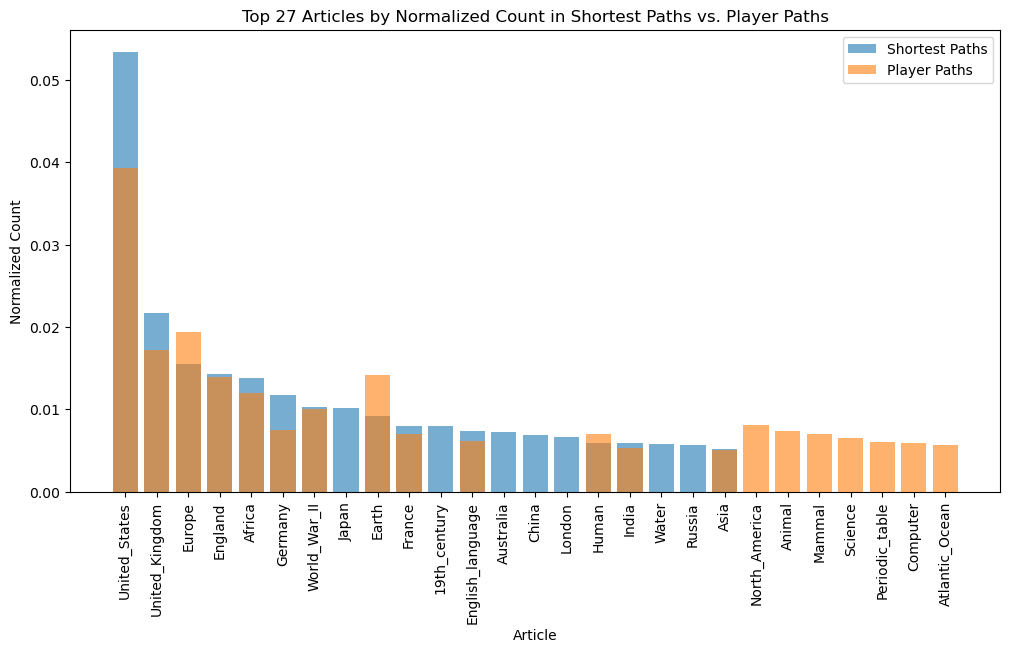

In [51]:
# Visualization of differences

# Bar plot of top N normalized article counts in each dataset
plt.figure(figsize=(12, 6))
plt.bar(top_SP.index, top_SP['Normalized_Count'], alpha=0.6, label='Shortest Paths')
plt.bar(top_player.index, top_player['Normalized_Count'], alpha=0.6, label='Player Paths')
plt.xticks(rotation=90)
plt.xlabel('Article')
plt.ylabel('Normalized Count')
plt.title(f'Top {N} Articles by Normalized Count in Shortest Paths vs. Player Paths')
plt.legend()
plt.show()


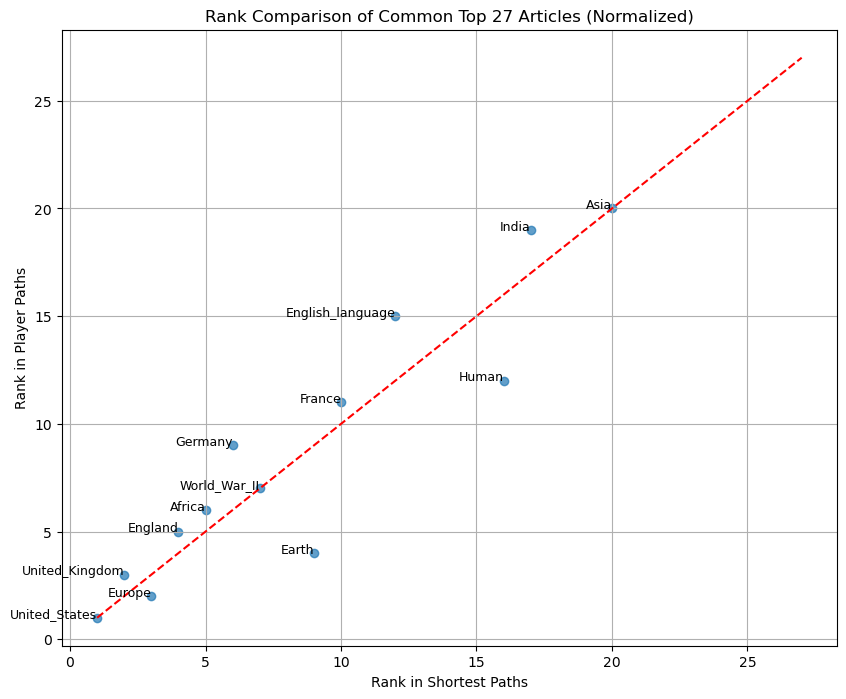

In [52]:
# Scatter plot of normalized ranks for common articles with labels and grid
plt.figure(figsize=(10, 8))

# Plot points
plt.scatter(common_ranks['Rank_SP'], common_ranks['Rank_Player'], alpha=0.7)

# Add labels for each point
for i in range(len(common_ranks)):
    article = common_ranks.index[i]
    plt.text(common_ranks['Rank_SP'].iloc[i], common_ranks['Rank_Player'].iloc[i], article, fontsize=9, ha='right')

# Add y=x line for reference
plt.plot([1, N], [1, N], 'r--')

# Labels and title
plt.xlabel('Rank in Shortest Paths')
plt.ylabel('Rank in Player Paths')
plt.title(f'Rank Comparison of Common Top {N} Articles (Normalized)')

# Add grid
plt.grid(True)

# Show plot
plt.show()

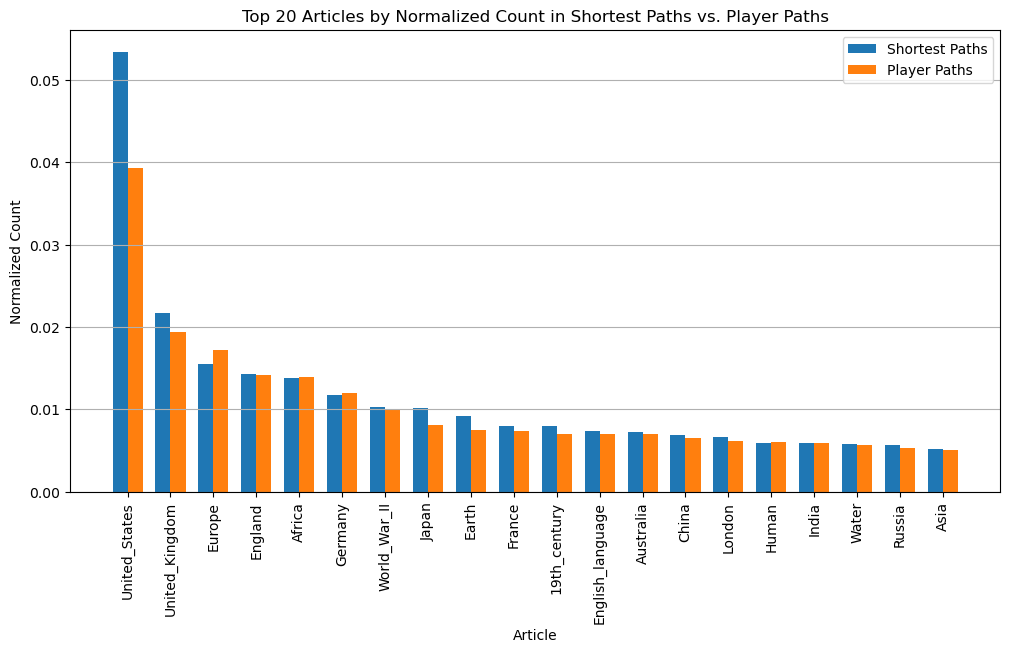

In [48]:
# Define the number of articles to plot
N = len(top_SP)

# Create an array of x positions for each article
x = np.arange(N)  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - width/2, top_SP['Normalized_Count'], width, label='Shortest Paths')
ax.bar(x + width/2, top_player['Normalized_Count'], width, label='Player Paths')

# Set x-tick labels to article names and adjust them
ax.set_xticks(x)
ax.set_xticklabels(top_SP.index, rotation=90)

# Labels and title
ax.set_xlabel('Article')
ax.set_ylabel('Normalized Count')
ax.set_title(f'Top {N} Articles by Normalized Count in Shortest Paths vs. Player Paths')
ax.legend()

# Add grid for readability
plt.grid(axis='y')

# Show plot
plt.show()

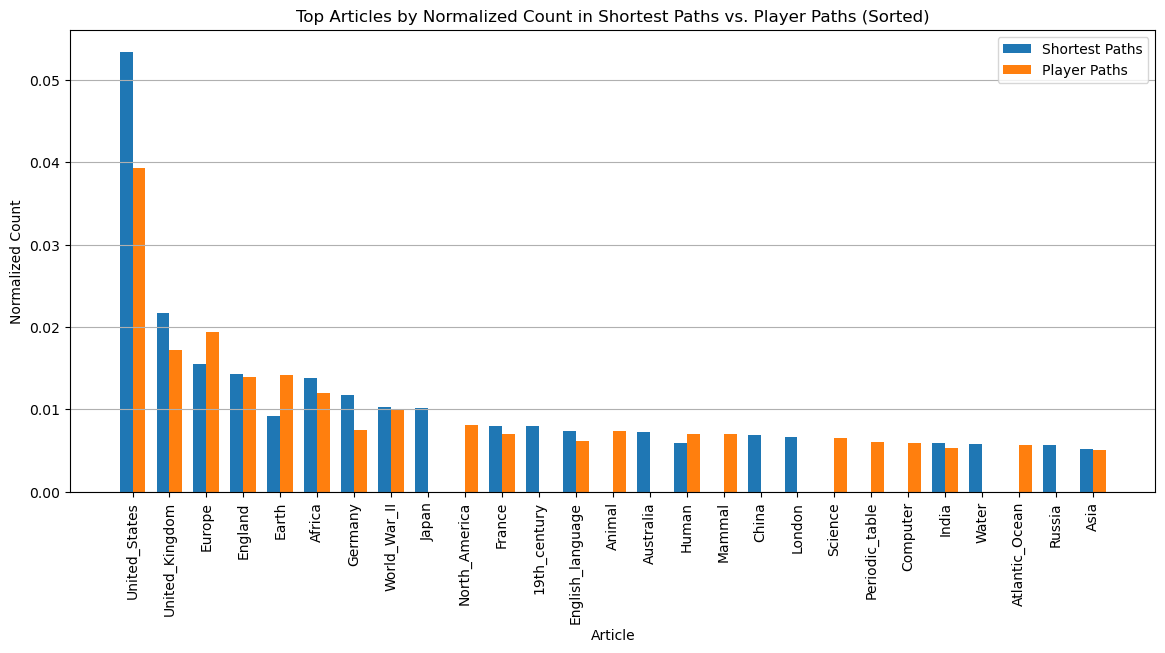

In [50]:
## not sure which of the 3 is best.
# Merge the two top N DataFrames on the 'Article' column, filling missing values with 0
merged_top = pd.merge(
    top_SP[['Normalized_Count']].rename(columns={'Normalized_Count': 'SP_Count'}),
    top_player[['Normalized_Count']].rename(columns={'Normalized_Count': 'Player_Count'}),
    left_index=True,
    right_index=True,
    how='outer'
).fillna(0)

# Sort the merged DataFrame by the maximum count between SP_Count and Player_Count, in descending order
merged_top['Max_Count'] = merged_top[['SP_Count', 'Player_Count']].max(axis=1)
merged_top = merged_top.sort_values(by='Max_Count', ascending=False).drop(columns='Max_Count')

# Define the number of articles in the sorted dataset
N = len(merged_top)

# Create an array of x positions for each article
x = np.arange(N)  # the label locations

# Define the width of the bars
width = 0.35  # the width of the bars

# Plot side-by-side bars
fig, ax = plt.subplots(figsize=(14, 6))
ax.bar(x - width/2, merged_top['SP_Count'], width, label='Shortest Paths')
ax.bar(x + width/2, merged_top['Player_Count'], width, label='Player Paths')

# Set x-tick labels to article names and adjust them
ax.set_xticks(x)
ax.set_xticklabels(merged_top.index, rotation=90)

# Labels and title
ax.set_xlabel('Article')
ax.set_ylabel('Normalized Count')
ax.set_title(f'Top Articles by Normalized Count in Shortest Paths vs. Player Paths (Sorted)')
ax.legend()

# Add grid for readability
plt.grid(axis='y')

# Show plot
plt.show()

In [40]:
# Convert article indices to sets for overlap analysis
SP_articles_set = set(SP_article_count['Article'])
player_articles_set = set(player_article_count['Article'])

# Intersection (articles in both datasets)
intersection_articles = SP_articles_set & player_articles_set
print("Articles in both datasets (Intersection):")
print(intersection_articles)

# Symmetric difference (articles unique to each dataset)
unique_to_SP = SP_articles_set - player_articles_set
unique_to_player = player_articles_set - SP_articles_set

print("\nArticles unique to shortest paths:")
print(unique_to_SP)

print("\nArticles unique to player paths:")
print(unique_to_player)


Articles in both datasets (Intersection):
{'United_States', 'Chester_A._Arthur', 'Seinfeld', 'Metal', 'Ceres_(dwarf_planet)', 'Space_station', 'Sub-Saharan_Africa', 'Rail_transport', 'Evolution', 'Rabies', 'Thomas_Aquinas', 'Selenium', "Pontiac's_Rebellion", 'Iridium', 'Baltic_Sea', 'Italian_War_of_1521', 'Iron(III)_chloride', 'Geography', 'Gull', 'Miocene', 'Franz_Schubert', 'Ultimatum_game', 'Beekeeping', 'Charles_V,_Holy_Roman_Emperor', 'British_East_India_Company', 'Greek_War_of_Independence', 'Epazote', 'Pollution', 'Irish_people', 'Hydrogen', 'William_Howard_Taft', 'Singapore', 'Nobelium', 'Socrates', 'Cricket', 'Millard_Fillmore', 'Natalie_Portman', 'Interpol', 'Irish_poetry', 'Gadolinium', 'Mary_II_of_England', '2005_Atlantic_hurricane_season', 'Company_(law)', 'PONG', 'Sultan', 'Meander', 'Niccolò_Paganini', 'Necktie', 'Kurt_Cobain', 'Burundi', 'Mali', 'Mauritius', 'Martin_Luther', 'Sesame', 'Magellanic_Penguin', 'George_Byron,_6th_Baron_Byron', 'Djibouti', 'Aberdeen', 'Africa